In [1]:
import cv2, time
import numpy as np
import torch
import matplotlib as mpl
from matplotlib import pyplot as plt

from utility.util import normalize_points
from utility.gms_matcher import GmsMatcher, DrawingType
from utility.log_detector import log_detect
from utility.models import create_loader, get_desc
from utility import models

n_channels, size = 3, 42
affine = False
with_scale, with_rotation = False, False
device = 'cpu' # or use 'cuda:0' if gpu is avaliable
pth_path = 'pretrained/PoreNet.pth'
coordconv = True

In [2]:
# Loading images
img1, img2 = cv2.imread('img/billgates1.jpg'), cv2.imread('img/billgates2.jpg')
img1_gray, img2_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
size1 = (img1.shape[1], img1.shape[0])
size2 = (img2.shape[1], img2.shape[0])
h1, w1, _ = img1.shape
h2, w2, _ = img2.shape
print('Image1 shape: ', img1.shape)
print('Image2 shape:', img2.shape)

Image1 shape:  (1697, 1241, 3)
Image2 shape: (1540, 1163, 3)


In [3]:
# Keypoint detection
blobs_log1 = log_detect(img1_gray, eliminate=True)
blobs_log2 = log_detect(img2_gray, eliminate=True)
pts1, sigma1 = np.float32(blobs_log1[:, :2]), blobs_log1[:, 2]
pts2, sigma2 = np.float32(blobs_log2[:, :2]), blobs_log2[:, 2]

In [4]:
# Create network and loader
net = models.HardNet(n_channels, size, coordconv=coordconv, affine=affine)
net.load_state_dict(torch.load(pth_path))
print('{} is loaded'.format(pth_path))
net.to(device)
net.eval()
patch_loader1 = create_loader(img1, pts1, sigma1, in_c=n_channels, size=size, bs=4096, coordconv=coordconv)
patch_loader2 = create_loader(img2, pts2, sigma2, in_c=n_channels, size=size, bs=4096, coordconv=coordconv)
desc1 = get_desc(net, patch_loader1, len(sigma1), device)
desc2 = get_desc(net, patch_loader2, len(sigma2), device)

pretrained/PoreNet.pth is loaded


/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:4255: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:4255: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:4255: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:4

No. of inliers:  555
Used 0.6175458431243896


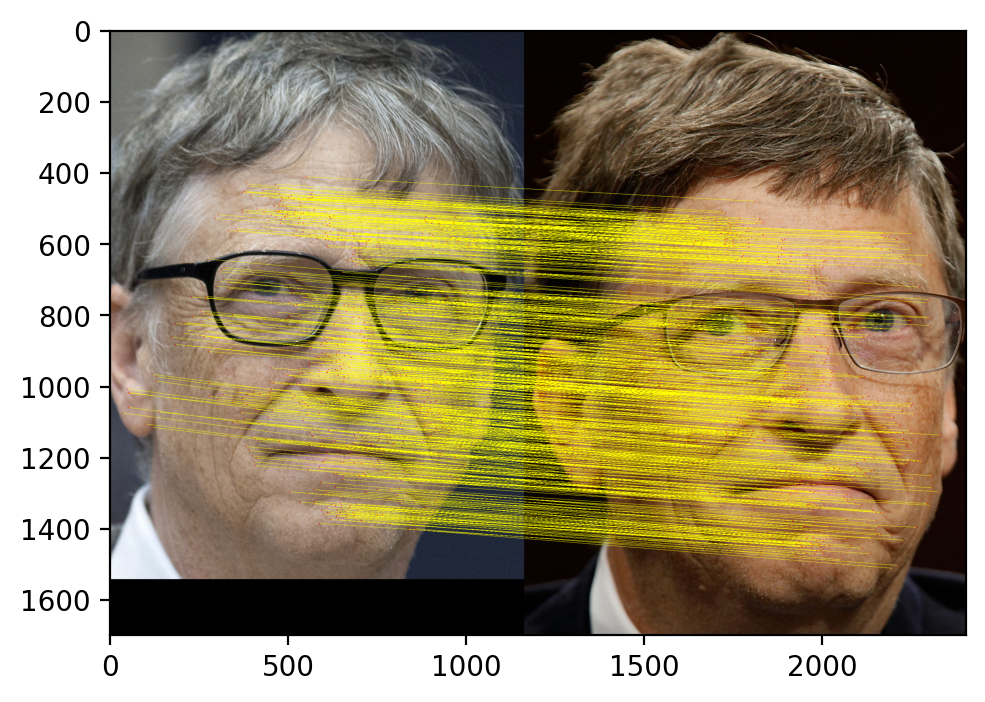

In [5]:
# Matching
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
gms = GmsMatcher(None, matcher)
pts1_norm, pts2_norm = [], []
normalize_points(pts1, size1, pts1_norm)
normalize_points(pts2, size2, pts2_norm)

query = {'norm_kpts': pts2_norm, 'descs': desc2}
gallery = {'norm_kpts': pts1_norm, 'descs': desc1}
start_time = time.time()
num_inliers = gms.match_from_kptdesc(query, gallery, with_scale, with_rotation, draw=True)
print('No. of inliers: ', num_inliers)
print("Used %s" % (time.time() - start_time))
output = gms.draw_matches_from_pts(img2, img1, pts2, pts1, DrawingType.LINES_AND_POINTS)
output = output[:,:,::-1]
mpl.rcParams['figure.dpi'] = 200
plt.imshow(output)